In [701]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from src.config import pr_root
from src.storage.excel_cdi import get_cdi_data
from src.storage.excel_ipca import get_ipca_data
from pathlib import Path
import pandas as pd

from src.visualization.plot import format_months, add_line, setup_plot

# Quando A Renda Fixa Protegeu Contra A Inflação.

O primeiro conselho de investimento que todo mundo escuta é que a poupança te faz perder dinheiro ao passar do tempo, e que a renda fixa é uma alternativa melhor para proteger o seu dinheiro contra a inflação. Mas quanto isso realmente é verdade? Essa proteção realmente é contínua? Vamos descobrir isso.

Temos, em notebooks/data, dados do CDI e do IPCA desde 2014. A gente começa com a extração desses dados.

In [702]:
df_cdi = get_cdi_data(data_dir=Path(pr_root / "notebooks/data"))  # Função em src/storage/cdi_excel.py
cdi_date = df_cdi['date']
cdi_yearly_rate_dec = df_cdi['cdi_annual_rate']

df_ipca = get_ipca_data(data_dir=Path(pr_root / "notebooks/data"))  # Função em src/storage/ipca_excel.py
ipca_date = df_ipca['date']
ipca_monthly_rate_dec = df_ipca['ipca_monthly_rate']

Vamos ordenar os dados em um novo dataframe. Para garantir que as duas taxas sejam alinhadas.

In [703]:
df = pd.merge(df_cdi[['date', 'cdi_annual_rate']],
              df_ipca[['date', 'ipca_monthly_rate']],
              on=['date'],               # Merge pela coluna date
              how='inner',               # Mantemos apenas as datas que existem em ambos os dataframes
              validate='many_to_many'    # Garantimos que não há duplicatas nas datas
).rename(columns={
    'cdi_annual_rate': 'cdi_yearly_rate_dec',
    'ipca_monthly_rate': 'ipca_monthly_rate_dec'
}).reset_index(drop=True)                # Resetamos o índice para evitar confusões futuras

Como o projeto ainda não armazena o IPCA anual, vamos calcular a taxa anual de cada mês (possível) a partir do IPCA mensal.

In [704]:
df['ipca_12m_rate_dec'] = (
    (df['ipca_monthly_rate_dec'] + 1)        # Convertendo a taxa mensal em fator de crescimento (1 + taxa)
    .rolling(window=12, min_periods=12)      # Criando uma janela móvel de 12 meses
    .apply(np.prod, raw=True)                # Calculando o produto dos fatores de crescimento na janela
    - 1
)

Agora, vamos descartar os 11 primeiros meses de 2014, que não tem o IPCA anual calculado.

In [705]:
df = df.dropna(subset=['ipca_12m_rate_dec']).reset_index(drop=True)

E vamos ver os resultados.

In [706]:
print(df)

        date  cdi_yearly_rate_dec  ipca_monthly_rate_dec  ipca_12m_rate_dec
0    2014-12               0.1151                 0.0078           0.064076
1    2015-01               0.1174                 0.0124           0.071378
2    2015-02               0.1209                 0.0122           0.077018
3    2015-03               0.1253                 0.0132           0.081286
4    2015-04               0.1263                 0.0071           0.081716
..       ...                  ...                    ...                ...
128  2025-08               0.1490                -0.0011           0.051305
129  2025-09               0.1490                 0.0048           0.051724
130  2025-10               0.1490                 0.0009           0.046808
131  2025-11               0.1490                 0.0018           0.044618
132  2025-12               0.1490                 0.0033           0.042644

[133 rows x 4 columns]


Perfeito! Agora, vamos plotar os dados. Para saber mais como essas funções funcionam, consulte [o segundo notebook da série (02_visualizacao_basica.ipynb)](./02_visualizacao_basica.ipynb) ou veja elas no código em `src/visualization/plot.py`.

Vamos começar formatando as datas para o eixo X.

In [707]:
dates_copy = pd.to_datetime(df['date'], format='%Y-%m')       # Convertemos para objetos datetime
years = dates_copy.dt.year                                    # Extraímos os anos

years_index = np.arange(len(years))                           # Criamos uma série de índices para o eixo X

# Aqui, encontramos as posições dos primeiros meses de cada ano
# Para utilizar como ticks e labels no eixo x do gráfico.
year_positions = years.drop_duplicates(keep='first').index.to_list()
year_labels = years.drop_duplicates(keep='first').astype(str).to_list()

# Removemos o label da primeira posição, porque ele é o único mês de 2014 que calculamos
# se ele aparecesse no gráfico, ele ficaria amontoado com 2015.
year_positions = year_positions[1:]
year_labels = year_labels[1:]

Como padrão, a Pipeline armazena todas os índices em decimal. Então vamos converter o valor em percentual para a visualização. Depois disso, plotamos as taxas anuais do CDI e do IPCA.

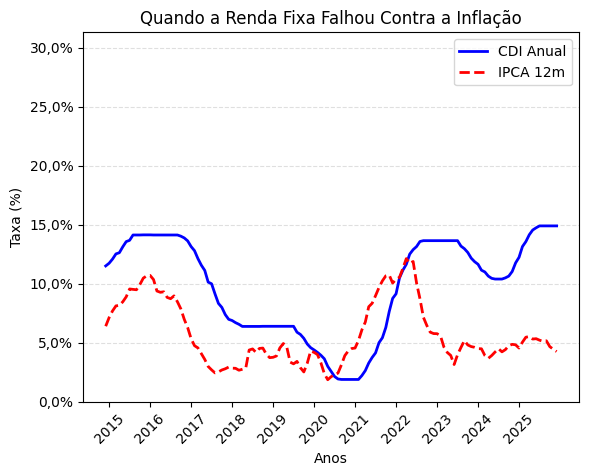

In [708]:
cdi_yearly_rate_perc = [rate * 100 for rate in df['cdi_yearly_rate_dec']]
ipca_12m_rate_perc = [rate * 100 for rate in df['ipca_12m_rate_dec']]

fig, ax = plt.subplots()

add_line(ax, years_index, cdi_yearly_rate_perc, color='blue', linestyle='solid', label='CDI Anual')
add_line(ax, years_index, ipca_12m_rate_perc, color='red', linestyle='dashed', label='IPCA 12m')

setup_plot(ax=ax,
           title='Quando a Renda Fixa Falhou Contra a Inflação',
           x_label='Anos',
           y_label='Taxa (%)',
           y_lim=(0, max(max(cdi_yearly_rate_perc), max(ipca_12m_rate_perc)) * 2.1),
           add_legend=True)

ax.set_xticks(year_positions)
ax.set_xticklabels(year_labels, rotation=45)


plt.show()

Interessante. Podemos ver que, no nosso recorte de tempo, o CDI foi maior do que a inflação, com exceção do período de 2020.
A taxa CDI caiu porque, durante a pandemia, o Banco Central reduziu a taxa Selic para estimular a economia, o que fez com que o CDI caísse. Você pode ler mais sobre isso [aqui](https://www.gov.br/pt-br/noticias/financas-impostos-e-gestao-publica/2020/02/banco-central-reduz-taxa-selic-para-4-25-ao-ano#:~:text=Banco%20Central%20reduz%20taxa%20Selic%20para%204%2C25%25%20ao%20ano.). Ao mesmo tempo, a inflação aumentou devido a diversos fatores relacionados à pandemia, como interrupções na cadeia de suprimentos e aumento dos preços de commodities.

Também podemos ver que houve uma queda gradual na taxa do CDI que comecou em 2017, e que a inflação reduziu junto. Isso também foi um corte da taxa Selic, por conta de um cenário econômico mais estável.

Poderiamos estudar e explicar esse gráfico ainda mais um pouco, mas queria avançar para uma outra visualização. Vamos calcular o spread do CDI contra a inflação, ou seja, a diferença entre o CDI e a inflação. E vamos plotar isso.



In [709]:
df['spread_cdi_ipca'] = df['cdi_yearly_rate_dec'] - df['ipca_12m_rate_dec']
spread_cdi_ipca_perc = [rate * 100 for rate in df['spread_cdi_ipca']]

Antes de plotar, vamos calcular o parâmetro y_lim para o gráfico, para que o 0% fique no meio do eixo X.

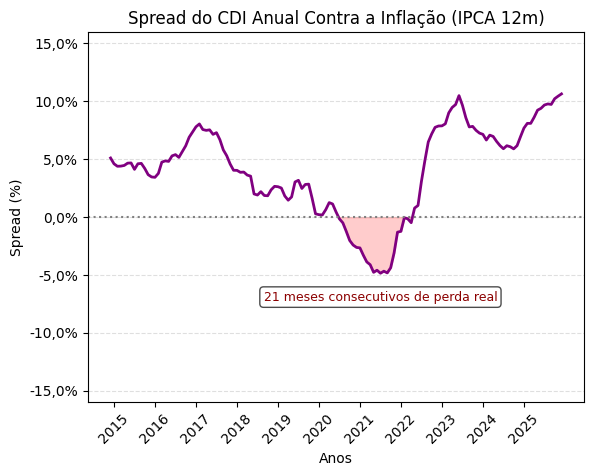

In [710]:
spread_arr = np.array(spread_cdi_ipca_perc)  #  Convertemos a série em um array numpy...
max_abs_spread = np.max(np.abs(spread_arr))  #  Procuramos o maior valor absoluto do spread...
pad_spread = max_abs_spread * 1.50           #  Adicionamos uma margem de 50% por estética...
y_lim_spread = (-pad_spread, pad_spread)     #  Por fim, definimos o y_lim



fig1, ax1 = plt.subplots()
add_line(ax1, years_index, spread_cdi_ipca_perc, color='purple', linestyle='solid')

setup_plot(ax=ax1,
           title='Spread do CDI Anual Contra a Inflação (IPCA 12m)',
           x_label='Anos',
           y_label='Spread (%)',
           y_lim=y_lim_spread)

ax1.set_xticks(year_positions)
ax1.set_xticklabels(year_labels, rotation=45)

# Para sombrear o gráfico quando o spread for negativo...
ax1.fill_between(years_index, 0, spread_cdi_ipca_perc,
                 where=(np.array(spread_cdi_ipca_perc) < 0),
                 color='red', alpha=0.2, interpolate=True)

# Para adicionar o label...
negative_mask = np.array(spread_cdi_ipca_perc) < 0    # Criamos uma máscara para saber quando é negativo
negative_indices = np.where(negative_mask)[0]         # Pegamos os índices onde o spread é negativo
min_idx = negative_indices[np.argmin(np.array(spread_cdi_ipca_perc)[negative_indices])]   # Encontramos o índice minimo

ax1.text(years_index[min_idx], spread_cdi_ipca_perc[min_idx] - 1.5,  # Colocamos o texto logo abaixo do ponto minimo
         '21 meses consecutivos de perda real',
         ha='center', va='top',
         fontsize=9, color='darkred',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))


ax1.axhline(y=0, color='gray', linestyle='dotted', linewidth=1.5, zorder=2)   # Destacamos o 0%

plt.show()

Aqui podemos ver o impacto de quando o CDI falhou contra a inflação. O spread negativo foi prolongado, e a recuperação foi lenta.

Antes de concluir, vamos anotar o primeiro gráfico.

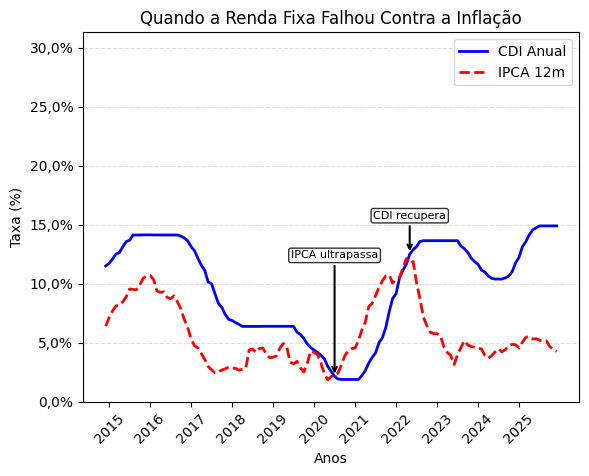

In [711]:
# Para encontrar onde o spread muda de positivo para negativo ou vice-versa...
crossover_indices = []
for i in range(1, len(spread_cdi_ipca_perc)):
    if (spread_cdi_ipca_perc[i - 1] >= 0 > spread_cdi_ipca_perc[i]) or \
       (spread_cdi_ipca_perc[i - 1] < 0 <= spread_cdi_ipca_perc[i]):
        crossover_indices.append(i)

fig2, ax2 = plt.subplots()

add_line(ax2, years_index, cdi_yearly_rate_perc, color='blue', linestyle='solid', label='CDI Anual')
add_line(ax2, years_index, ipca_12m_rate_perc, color='red', linestyle='dashed', label='IPCA 12m')

setup_plot(ax=ax2,
           title='Quando a Renda Fixa Falhou Contra a Inflação',
           x_label='Anos',
           y_label='Taxa (%)',
           y_lim=(0, max(max(cdi_yearly_rate_perc), max(ipca_12m_rate_perc)) * 2.1),
           add_legend=True)

ax2.set_xticks(year_positions)
ax2.set_xticklabels(year_labels, rotation=45)

# Agora, vamos adicionar as anotações nos pontos de crossover...
for idx in crossover_indices:
    if spread_cdi_ipca_perc[idx] < 0:
        label = 'IPCA ultrapassa'
        y_text = cdi_yearly_rate_perc[idx] + 10
    else:
        label = 'CDI recupera'
        y_text = cdi_yearly_rate_perc[idx] + 3

    #  E anotamos o gráfico com uma seta apontando para o ponto de crossover
    ax2.annotate(label,
                xy=(years_index[idx], cdi_yearly_rate_perc[idx]),
                xytext=(years_index[idx], y_text),
                ha='center',
                fontsize=8,
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8))

plt.show()

Perfeito, agora podemos ver claramente os momentos de ultrapassagem.

Bem, mas no fim de tudo isso, o que concluímos?
Embora a renda fixa tenha protegido contra a inflação em quase todo o período que analisamos, os dados mostram que essa proteção não é garantida. O ponto central aqui não é só que às vezes a economia sofre crises enormes que afetam o CDI, mas sim que quando essas crises acontecem, o mecanismo de ajuste da taxa de juros (no qual o CDI acompanha) demora a reagir. Isso significa que a renda fixa pode falhar justamente nos momentos iniciais da explosão da inflação, e continuar baixa por um bom tempo durante a crise, quando a preservação do poder de compra é mais importante do que nunca.

Assim, o risco da renda fixa não é só a crise, mas no tempo necessário para que a taxa de juros recupere. Isso reforça a importância de diversificar os investimentos e de estar atento ao cenário econômico para tomar decisões informadas.